In [28]:
import numpy as np
import matplotlib.pyplot as plt
from env.mdp import MarkovDecisionProcess
from env.gridworld import Gridworld, gridplot
from algs.lps import unregCMDPLP
from typing import List, Tuple
Point = Tuple[int,int]
Goal = Tuple[Point,float]

### Solving unregularized CMDPS with the LP formulation

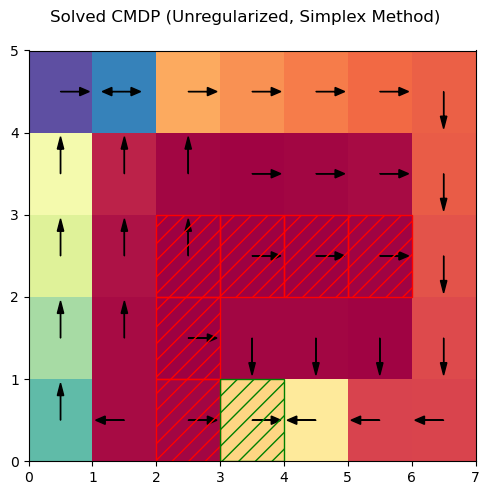

In [29]:
goals = [((3,0),2)]
obstacles = [(2,0),(3,2),(2,1),(2,2),(4,2),(5,2)]
MDP = Gridworld(7,5,0.1,0.9,goals=goals,obstacles=obstacles) #build a "wall of obstacles"
MDP.Psi = MDP.Psi*200
solver = unregCMDPLP(MDP)
mu = solver.solve()

sz = 5.

fig, ax = plt.subplots(1,1,figsize=(sz,sz))
plot = np.average(MDP.states2grid(mu),axis=2)
gridplot(MDP,ax,np.average(mu,axis=1),stochastic_policy=solver.recover_stochastic_policy(),obstacles=obstacles,goals=goals)
fig.suptitle('Solved CMDP (Unregularized, Simplex Method)')
fig.tight_layout()